In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
import sqlparse
import sqlglot
from collections import Counter
import re
import logging
from dotenv import load_dotenv
from transformers import AutoTokenizer # Needed for token analysis


In [2]:
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s",
    handlers=[logging.StreamHandler(sys.stdout)]
)
logger = logging.getLogger(__name__)


In [3]:
# Ensures HF_TOKEN is loaded if required by the tokenizer/model
load_dotenv()
hf_token = os.getenv('HF_TOKEN')


In [4]:
# Assuming the script is run from the project's base directory ('Finetuning/')
base_dir = "." # Current directory where the script is run
viz_dir = os.path.join(base_dir, 'visualizations')
# Define model whose tokenizer will be used for analysis
model_name = "google/gemma-3-1b-it"
dataset_name = "gretelai/synthetic_text_to_sql"
eda_sample_size = 1000 # Sample size for potentially slow checks like validity/token counts

# Create visualization directory if it doesn't exist
os.makedirs(viz_dir, exist_ok=True)

logger.info(f"Running EDA from base directory: {os.path.abspath(base_dir)}")
logger.info(f"Saving visualizations to: {viz_dir}")


2025-04-21 17:54:16,603 - __main__ - INFO - Running EDA from base directory: /Users/udaykiran/Documents/NEU/Prompt Engineering/Finetuning/refined
2025-04-21 17:54:16,603 - __main__ - INFO - Saving visualizations to: ./visualizations


In [5]:
logger.info(f"Loading dataset: {dataset_name}...")
try:
    # Load the dataset from Hugging Face
    dataset = load_dataset(dataset_name)
    logger.info(f"Dataset loaded successfully. Available splits: {list(dataset.keys())}")
except Exception as e:
    logger.error(f"Fatal: Failed to load dataset '{dataset_name}'. Error: {e}")
    if "authentication" in str(e).lower():
         logger.error("Try logging in via `huggingface-cli login` or ensuring HF_TOKEN is set.")
    sys.exit(1) # Exit if dataset loading fails


2025-04-21 17:54:16,607 - __main__ - INFO - Loading dataset: gretelai/synthetic_text_to_sql...
2025-04-21 17:54:19,263 - __main__ - INFO - Dataset loaded successfully. Available splits: ['train', 'test']


In [6]:
# Ensure the 'train' split exists, as it's commonly used for EDA
if 'train' not in dataset:
    logger.error("Fatal: 'train' split not found in the loaded dataset.")
    sys.exit(1)

logger.info(f"Train dataset size: {len(dataset['train'])}")
# Check for 'test' split and report its size if available
if 'test' in dataset:
    logger.info(f"Test dataset size: {len(dataset['test'])}")
else:
    logger.info("No 'test' split found in the dataset.")

# Display a few sample data points from the training set
logger.info("\nSample data from training set:")
num_samples_to_show = 3
for i in range(min(num_samples_to_show, len(dataset['train']))):
    print(f"\n--- Sample {i+1} ---")
    sample = dataset['train'][i]
    # Print key fields relevant to Text-to-SQL, truncating long text
    for key in ['id', 'domain', 'sql_complexity', 'sql_task_type', 'sql_prompt', 'sql', 'sql_context']:
        if key in sample:
            # Convert value to string and truncate for display
            value_str = str(sample[key])
            print(f"{key}: {value_str[:200]}{'...' if len(value_str) > 200 else ''}")
    print("-" * 80)

# Display the schema (features) of the training dataset
logger.info("\nDataset schema (train split):")
print(dataset['train'].features)


2025-04-21 17:54:19,269 - __main__ - INFO - Train dataset size: 100000
2025-04-21 17:54:19,269 - __main__ - INFO - Test dataset size: 5851
2025-04-21 17:54:19,270 - __main__ - INFO - 
Sample data from training set:

--- Sample 1 ---
id: 5097
domain: forestry
sql_complexity: single join
sql_task_type: analytics and reporting
sql_prompt: What is the total volume of timber sold by each salesperson, sorted by salesperson?
sql: SELECT salesperson_id, name, SUM(volume) as total_volume FROM timber_sales JOIN salesperson ON timber_sales.salesperson_id = salesperson.salesperson_id GROUP BY salesperson_id, name ORDER BY total_vol...
sql_context: CREATE TABLE salesperson (salesperson_id INT, name TEXT, region TEXT); INSERT INTO salesperson (salesperson_id, name, region) VALUES (1, 'John Doe', 'North'), (2, 'Jane Smith', 'South'); CREATE TABLE ...
--------------------------------------------------------------------------------

--- Sample 2 ---
id: 5098
domain: defense industry
sql_complexity: agg

In [7]:
logger.info("Converting train split to Pandas DataFrame for easier analysis...")
df_train = None # Initialize to None
try:
    df_train = pd.DataFrame(dataset['train'])
    logger.info(f"Train DataFrame created with shape: {df_train.shape}")

    # Convert test split to DataFrame if it exists
    df_test = None
    if 'test' in dataset:
        logger.info("Converting test split to Pandas DataFrame...")
        df_test = pd.DataFrame(dataset['test'])
        logger.info(f"Test DataFrame created with shape: {df_test.shape}")

except Exception as e:
    logger.error(f"Error converting dataset splits to Pandas DataFrames: {e}")
    # Exiting as DataFrame is crucial for subsequent steps
    sys.exit(1)


2025-04-21 17:54:19,276 - __main__ - INFO - Converting train split to Pandas DataFrame for easier analysis...
2025-04-21 17:54:22,671 - __main__ - INFO - Train DataFrame created with shape: (100000, 11)
2025-04-21 17:54:22,671 - __main__ - INFO - Converting test split to Pandas DataFrame...
2025-04-21 17:54:22,899 - __main__ - INFO - Test DataFrame created with shape: (5851, 11)


In [8]:
logger.info("\nBasic DataFrame statistics (Train):")
print(f"Columns: {df_train.columns.tolist()}")
print("\nNA values per column (Train):")
# Display columns with any NA values
na_counts = df_train.isna().sum()
print(na_counts[na_counts > 0])
if na_counts.sum() == 0:
    print("No NA values found in the training DataFrame.")
else:
    logger.warning("NA values found. Consider imputation or removal depending on analysis needs.")
    # Depending on which columns have NAs, subsequent steps might fail. Add handling if needed.


2025-04-21 17:54:22,903 - __main__ - INFO - 
Basic DataFrame statistics (Train):
Columns: ['id', 'domain', 'domain_description', 'sql_complexity', 'sql_complexity_description', 'sql_task_type', 'sql_task_type_description', 'sql_prompt', 'sql_context', 'sql', 'sql_explanation']

NA values per column (Train):
Series([], dtype: int64)
No NA values found in the training DataFrame.


2025-04-21 17:54:22,945 - __main__ - INFO - 
Analyzing categorical distributions (Train split)...
2025-04-21 17:54:22,959 - __main__ - INFO - Number of unique domains: 100
2025-04-21 17:54:22,960 - __main__ - INFO - Number of SQL complexity types: 8
2025-04-21 17:54:22,960 - __main__ - INFO - Number of SQL task types: 4


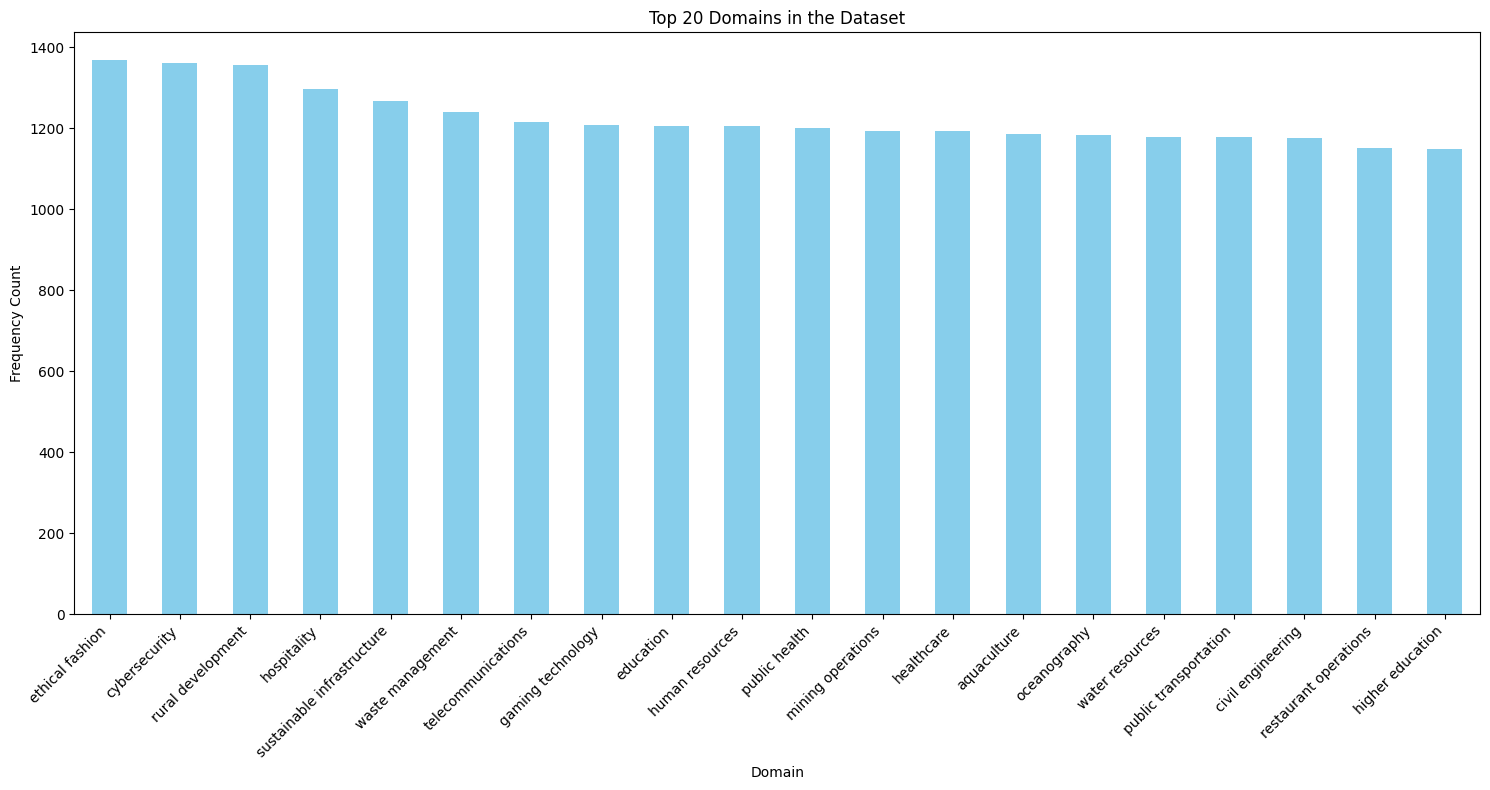

2025-04-21 17:54:23,103 - __main__ - INFO - Saved domain distribution plot to './visualizations/domain_distribution.png'


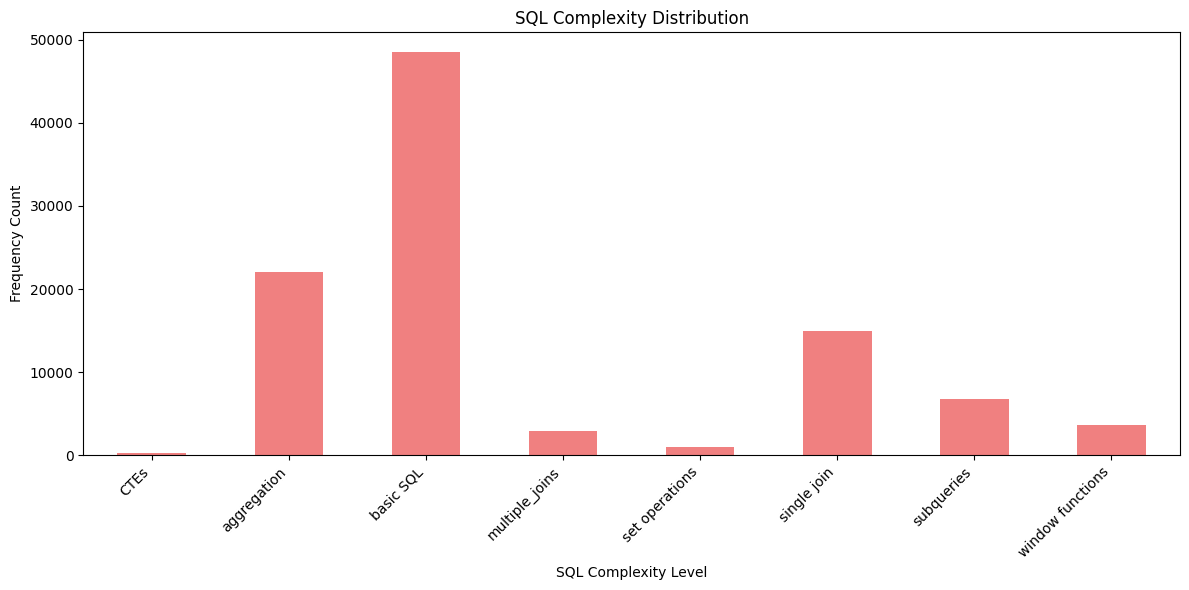

2025-04-21 17:54:23,183 - __main__ - INFO - Saved SQL complexity plot to './visualizations/sql_complexity_distribution.png'


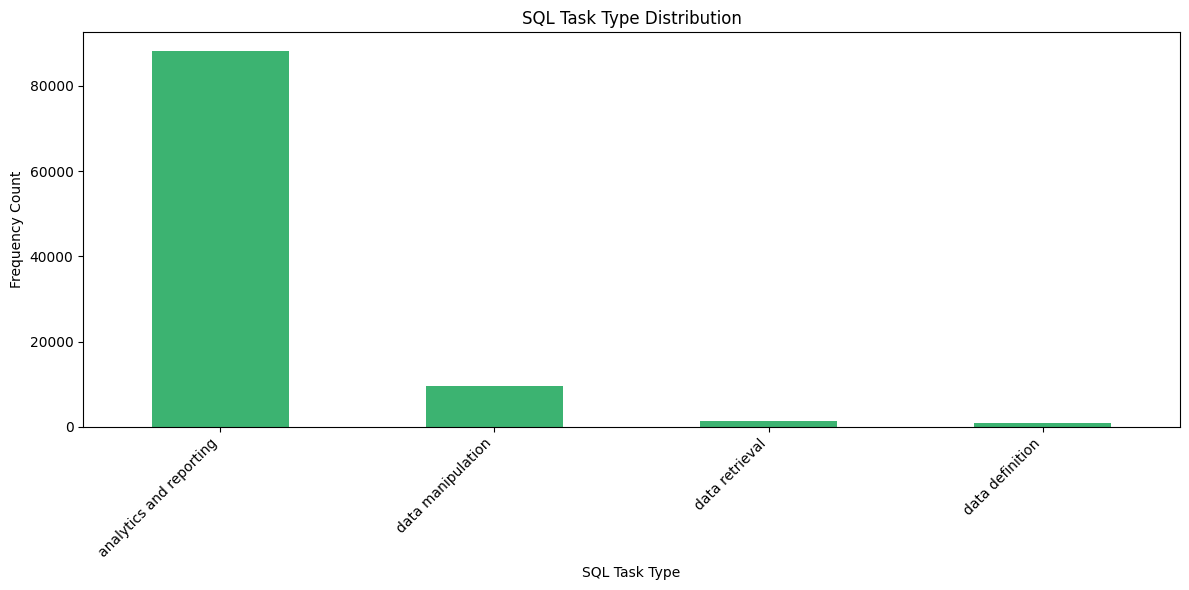

2025-04-21 17:54:23,276 - __main__ - INFO - Saved SQL task type plot to './visualizations/sql_task_distribution.png'

--- Top 10 Domains ---
domain
ethical fashion               1368
cybersecurity                 1360
rural development             1357
hospitality                   1296
sustainable infrastructure    1266
waste management              1240
telecommunications            1216
gaming technology             1208
education                     1204
human resources               1204
Name: count, dtype: int64

--- SQL Complexity Counts ---
sql_complexity
basic SQL           48466
aggregation         22015
single join         14932
subqueries           6719
window functions     3596
multiple_joins       2949
set operations       1050
CTEs                  273
Name: count, dtype: int64

--- SQL Task Type Counts ---
sql_task_type
analytics and reporting    88186
data manipulation           9665
data retrieval              1309
data definition              840
Name: count, dtype: 

In [9]:
logger.info("\nAnalyzing categorical distributions (Train split)...")
try:
    # Calculate value counts for key categorical columns
    domain_counts = df_train['domain'].value_counts()
    sql_complexity_counts = df_train['sql_complexity'].value_counts()
    sql_task_counts = df_train['sql_task_type'].value_counts()

    logger.info(f"Number of unique domains: {len(domain_counts)}")
    logger.info(f"Number of SQL complexity types: {len(sql_complexity_counts)}")
    logger.info(f"Number of SQL task types: {len(sql_task_counts)}")

    # Plot domain distribution (Top 20)
    plt.figure(figsize=(15, 8))
    domain_counts.head(20).plot(kind='bar', color='skyblue')
    plt.title('Top 20 Domains in the Dataset')
    plt.xlabel('Domain')
    plt.ylabel('Frequency Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(os.path.join(viz_dir, 'domain_distribution.png'))
    plt.show() # Show the plot
    plt.close() # Close plot object
    logger.info(f"Saved domain distribution plot to '{os.path.join(viz_dir, 'domain_distribution.png')}'")

    # Plot SQL complexity distribution
    plt.figure(figsize=(12, 6))
    sql_complexity_counts.sort_index().plot(kind='bar', color='lightcoral')
    plt.title('SQL Complexity Distribution')
    plt.xlabel('SQL Complexity Level')
    plt.ylabel('Frequency Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(os.path.join(viz_dir, 'sql_complexity_distribution.png'))
    plt.show() # Show the plot
    plt.close() # Close plot object
    logger.info(f"Saved SQL complexity plot to '{os.path.join(viz_dir, 'sql_complexity_distribution.png')}'")

    # Plot SQL task type distribution
    plt.figure(figsize=(12, 6))
    sql_task_counts.plot(kind='bar', color='mediumseagreen')
    plt.title('SQL Task Type Distribution')
    plt.xlabel('SQL Task Type')
    plt.ylabel('Frequency Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(os.path.join(viz_dir, 'sql_task_distribution.png'))
    plt.show() # Show the plot
    plt.close() # Close plot object
    logger.info(f"Saved SQL task type plot to '{os.path.join(viz_dir, 'sql_task_distribution.png')}'")

    # Print summary counts
    print("\n--- Top 10 Domains ---")
    print(domain_counts.head(10))
    print("\n--- SQL Complexity Counts ---")
    print(sql_complexity_counts)
    print("\n--- SQL Task Type Counts ---")
    print(sql_task_counts)

except KeyError as e:
    logger.error(f"Missing expected column for categorical analysis: {e}")
except Exception as e:
    logger.error(f"Error during categorical distribution analysis: {e}")


2025-04-21 17:54:23,283 - __main__ - INFO - 
Analyzing relationship between Domain and SQL Complexity...


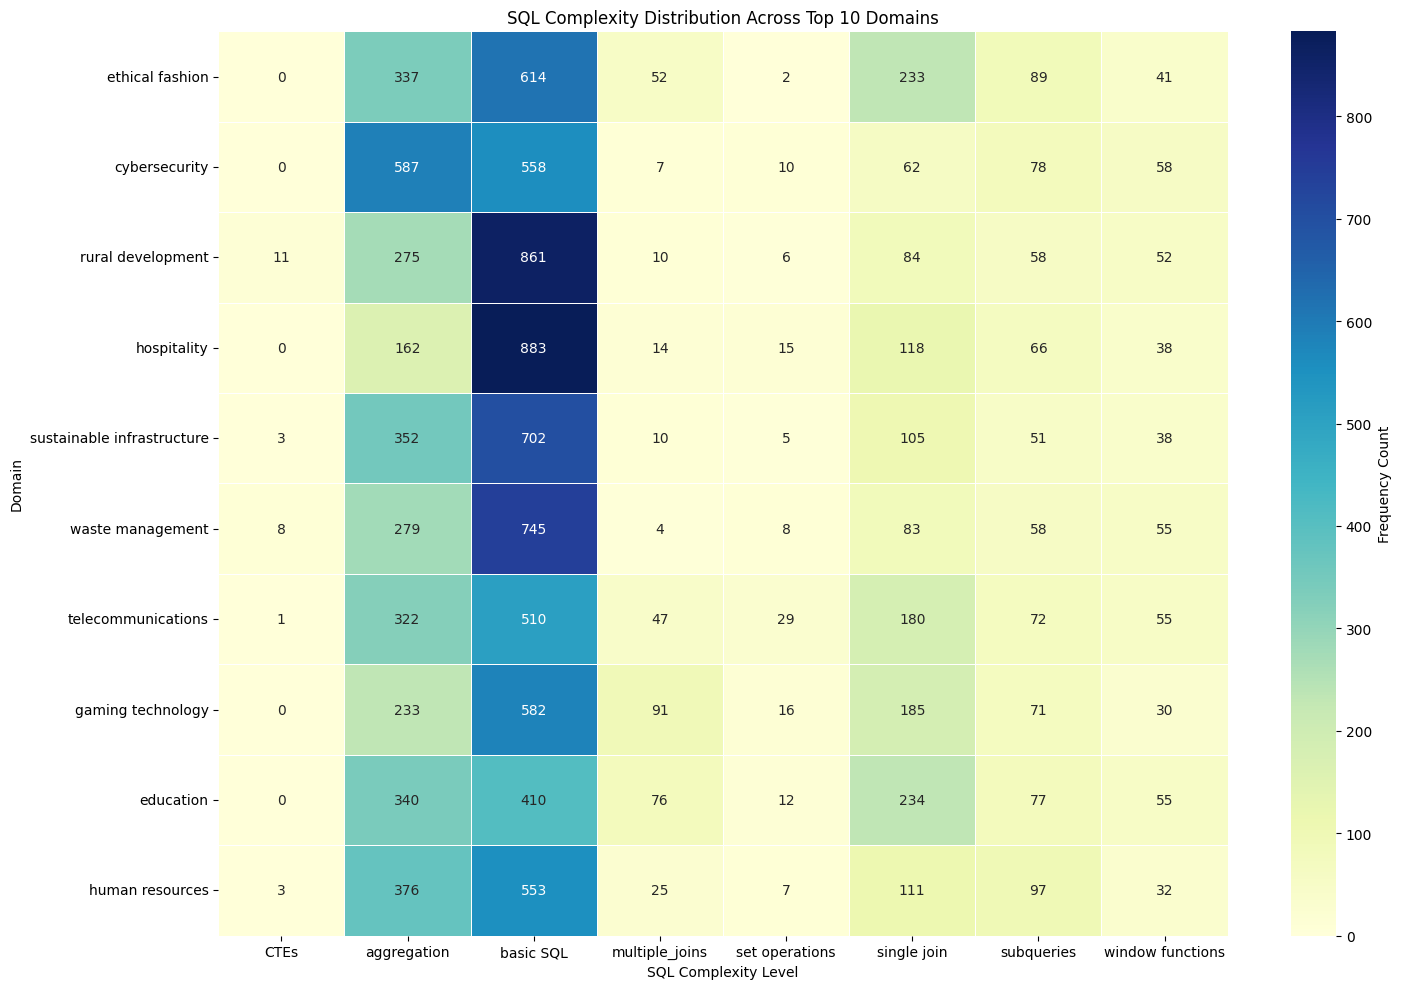

2025-04-21 17:54:23,485 - __main__ - INFO - Saved domain vs. complexity heatmap to './visualizations/domain_complexity_heatmap.png'


In [10]:
logger.info("\nAnalyzing relationship between Domain and SQL Complexity...")
try:
    # Create a cross-tabulation
    domain_complexity_matrix = pd.crosstab(df_train['domain'], df_train['sql_complexity'])

    # Select top N domains for clearer visualization
    top_n_domains = 10
    # Recalculate domain_counts if needed (e.g., if previous cell failed)
    if 'domain_counts' not in locals():
         domain_counts = df_train['domain'].value_counts()
    top_domains = domain_counts.head(top_n_domains).index
    # Ensure all top domains exist in the matrix index before selecting
    top_domains_present = [d for d in top_domains if d in domain_complexity_matrix.index]
    if not top_domains_present:
        raise ValueError("None of the top domains found in the domain_complexity_matrix index.")
    domain_complexity_subset = domain_complexity_matrix.loc[top_domains_present]


    # Plot heatmap
    plt.figure(figsize=(15, 10))
    sns.heatmap(domain_complexity_subset, cmap="YlGnBu", annot=True, fmt='d', linewidths=.5, cbar_kws={'label': 'Frequency Count'})
    plt.title(f'SQL Complexity Distribution Across Top {len(top_domains_present)} Domains')
    plt.ylabel('Domain')
    plt.xlabel('SQL Complexity Level')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(os.path.join(viz_dir, 'domain_complexity_heatmap.png'))
    plt.show() # Show the plot
    plt.close() # Close plot object
    logger.info(f"Saved domain vs. complexity heatmap to '{os.path.join(viz_dir, 'domain_complexity_heatmap.png')}'")

except KeyError as e:
     logger.error(f"Missing expected column for domain/complexity analysis: {e}")
except ValueError as e:
     logger.error(f"Value error during domain/complexity analysis: {e}")
except Exception as e:
    logger.error(f"Error during domain vs. complexity analysis: {e}")



2025-04-21 17:54:23,491 - __main__ - INFO - 
Analyzing character length distributions (Prompt, SQL, Context)...


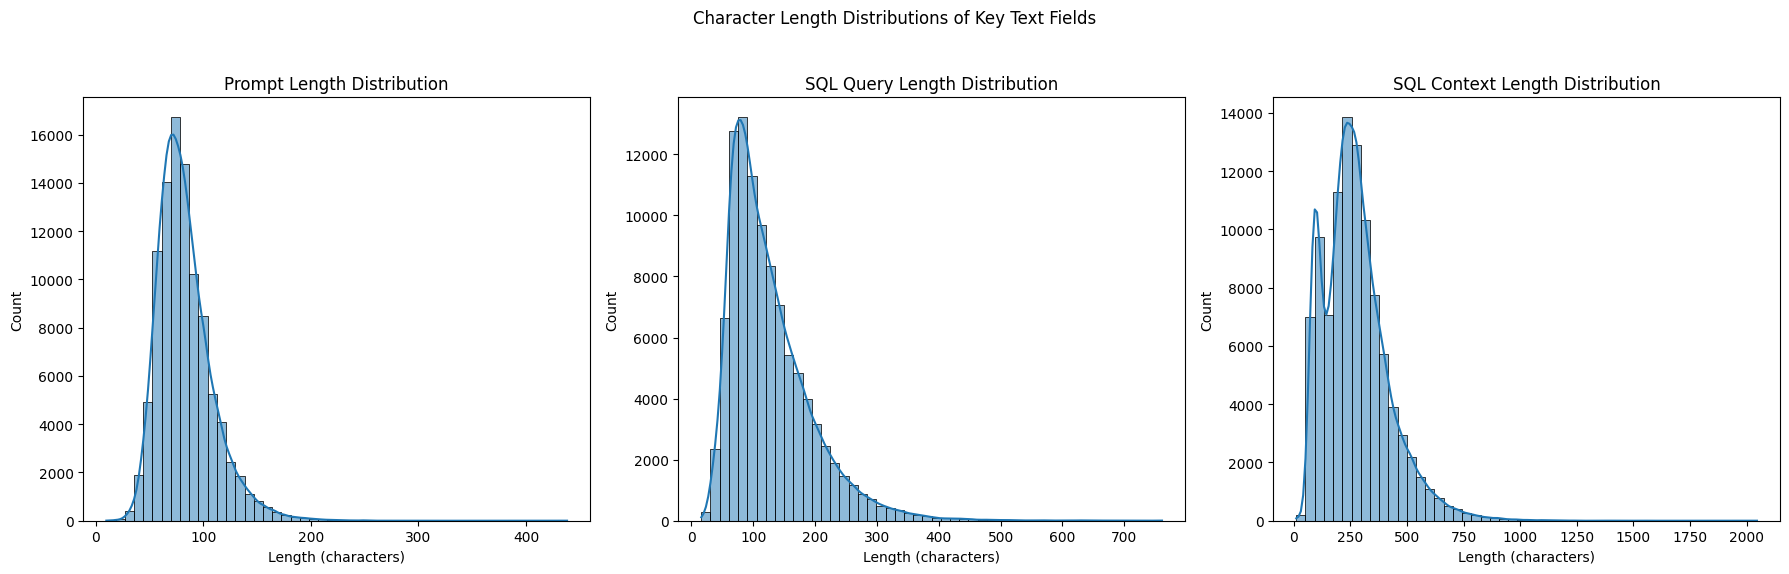

2025-04-21 17:54:24,102 - __main__ - INFO - Saved length distribution plots to './visualizations/length_distributions.png'

--- Prompt Length Stats ---
count    100000.000000
mean         83.146220
std          25.866902
min          10.000000
25%          65.000000
50%          79.000000
75%          96.000000
max         438.000000
Name: prompt_length, dtype: float64

--- SQL Length Stats ---
count    100000.000000
mean        127.137480
std          67.383741
min          16.000000
25%          79.000000
50%         111.000000
75%         159.000000
max         761.000000
Name: sql_length, dtype: float64

--- Context Length Stats ---
count    100000.000000
mean        276.295940
std         144.142554
min          11.000000
25%         178.000000
50%         258.000000
75%         349.000000
max        2046.000000
Name: context_length, dtype: float64


In [11]:
logger.info("\nAnalyzing character length distributions (Prompt, SQL, Context)...")
try:
    # Ensure columns exist and calculate lengths safely (converting potential non-strings)
    df_train['prompt_length'] = df_train['sql_prompt'].astype(str).apply(len)
    df_train['sql_length'] = df_train['sql'].astype(str).apply(len)
    df_train['context_length'] = df_train['sql_context'].astype(str).apply(len)

    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    sns.histplot(df_train['prompt_length'], bins=50, kde=True)
    plt.title('Prompt Length Distribution')
    plt.xlabel('Length (characters)')
    plt.ylabel('Count')

    plt.subplot(1, 3, 2)
    sns.histplot(df_train['sql_length'], bins=50, kde=True)
    plt.title('SQL Query Length Distribution')
    plt.xlabel('Length (characters)')

    plt.subplot(1, 3, 3)
    sns.histplot(df_train['context_length'], bins=50, kde=True)
    plt.title('SQL Context Length Distribution')
    plt.xlabel('Length (characters)')

    plt.suptitle('Character Length Distributions of Key Text Fields')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.savefig(os.path.join(viz_dir, 'length_distributions.png'))
    plt.show() # Show the plot
    plt.close() # Close plot object
    logger.info(f"Saved length distribution plots to '{os.path.join(viz_dir, 'length_distributions.png')}'")

    # Print descriptive statistics for lengths
    print("\n--- Prompt Length Stats ---")
    print(df_train['prompt_length'].describe())
    print("\n--- SQL Length Stats ---")
    print(df_train['sql_length'].describe())
    print("\n--- Context Length Stats ---")
    print(df_train['context_length'].describe())

except KeyError as e:
     logger.error(f"Missing expected column for length analysis: {e}")
except Exception as e:
    logger.error(f"Error during text length analysis: {e}")



2025-04-21 17:54:24,118 - __main__ - INFO - 
Analyzing SQL keywords using sqlparse...
2025-04-21 17:54:24,121 - __main__ - INFO - Extracting keywords from SQL queries...
2025-04-21 17:54:40,145 - __main__ - INFO - Keyword extraction complete.


/var/folders/zw/rm73pxq9065980p1jg6sh01r0000gn/T/ipykernel_30820/4268072529.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=keyword_df.index, y='count', data=keyword_df, palette='viridis')


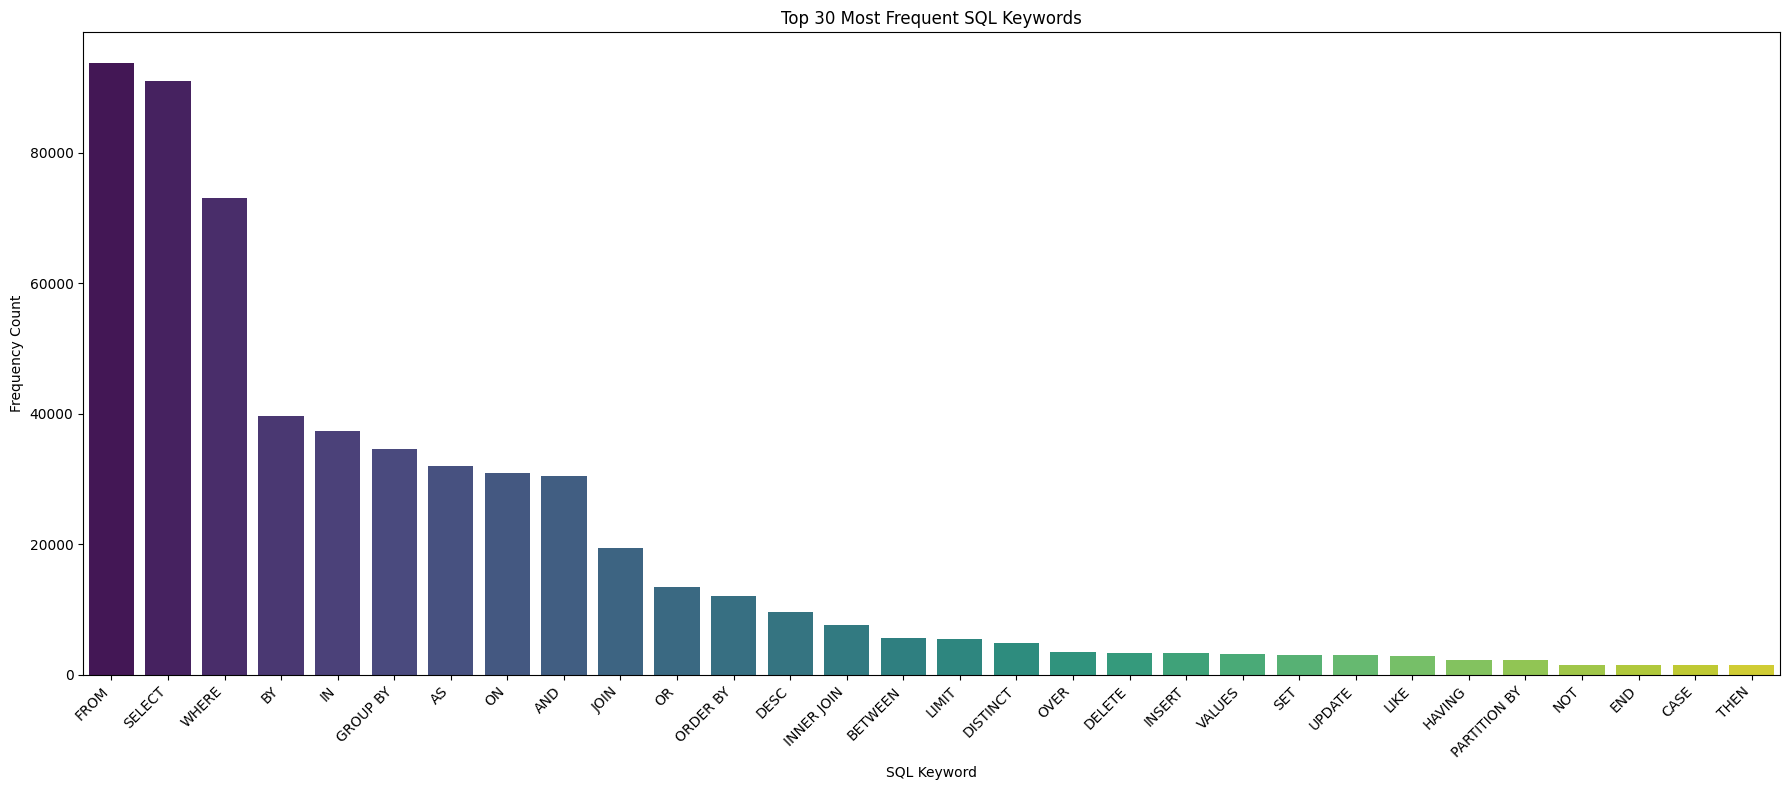

2025-04-21 17:54:40,341 - __main__ - INFO - Saved keyword distribution plot to './visualizations/keyword_distribution.png'

--- Top 30 Keywords ---
              count
FROM          93772
SELECT        90926
WHERE         72999
BY            39659
IN            37359
GROUP BY      34543
AS            31940
ON            30852
AND           30444
JOIN          19444
OR            13407
ORDER BY      12126
DESC           9590
INNER JOIN     7609
BETWEEN        5701
LIMIT          5466
DISTINCT       4885
OVER           3464
DELETE         3363
INSERT         3295
VALUES         3164
SET            3068
UPDATE         3030
LIKE           2940
HAVING         2237
PARTITION BY   2187
NOT            1555
END            1527
CASE           1525
THEN           1525


In [12]:
logger.info("\nAnalyzing SQL keywords using sqlparse...")
try:
    def get_sql_keywords(sql):
        """Extract SQL keywords from a query using sqlparse."""
        try:
            # Normalize case for consistent keyword matching
            formatted_sql = sqlparse.format(str(sql), keyword_case='upper', identifier_case='lower')
            # Define a comprehensive set of common SQL keywords
            keywords = {
                'SELECT', 'FROM', 'WHERE', 'JOIN', 'INNER JOIN', 'LEFT JOIN', 'RIGHT JOIN', 'FULL OUTER JOIN',
                'GROUP BY', 'ORDER BY', 'HAVING', 'LIMIT', 'OFFSET', 'DISTINCT', 'UNION', 'UNION ALL', 'INTERSECT', 'EXCEPT',
                'COUNT', 'SUM', 'AVG', 'MIN', 'MAX', 'INSERT', 'UPDATE', 'DELETE', 'CREATE', 'ALTER', 'DROP', 'TRUNCATE',
                'WITH', 'AS', 'CASE', 'WHEN', 'THEN', 'ELSE', 'END', 'LIKE', 'ILIKE', 'IN', 'NOT IN', 'BETWEEN', 'IS NULL', 'IS NOT NULL',
                'EXISTS', 'NOT EXISTS', 'AND', 'OR', 'NOT', 'OVER', 'PARTITION BY', 'ROWS', 'RANGE', 'PRECEDING', 'FOLLOWING',
                'UNBOUNDED', 'CURRENT ROW', 'RANK', 'DENSE_RANK', 'ROW_NUMBER', 'NTILE', 'LAG', 'LEAD', 'FIRST_VALUE', 'LAST_VALUE',
                'VALUES', 'SET', 'BY', 'ON', 'DESC', 'ASC' # Added more common ones
            }
            # Find which keywords from the set are present in the formatted SQL
            found_keywords = {kw for kw in keywords if kw in formatted_sql}
            return list(found_keywords)
        except Exception as e:
            # Log details for debugging specific SQL parsing errors if needed
            # logger.debug(f"Could not parse SQL for keywords: {str(sql)[:100]}... Error: {e}")
            return [] # Return empty list on error

    # Apply keyword extraction (this might take a short while on the full dataset)
    logger.info("Extracting keywords from SQL queries...")
    df_train['sql_keywords'] = df_train['sql'].apply(get_sql_keywords)
    logger.info("Keyword extraction complete.")

    # Count frequencies of all extracted keywords
    all_keywords = [keyword for keywords_list in df_train['sql_keywords'] for keyword in keywords_list]
    keyword_counts = Counter(all_keywords)

    # Plot keyword distribution (Top 30)
    if keyword_counts:
        plt.figure(figsize=(18, 8))
        # Create DataFrame from Counter for easy plotting
        keyword_df = pd.DataFrame.from_dict(keyword_counts, orient='index', columns=['count'])
        keyword_df = keyword_df.sort_values('count', ascending=False).head(30)

        sns.barplot(x=keyword_df.index, y='count', data=keyword_df, palette='viridis')
        plt.title('Top 30 Most Frequent SQL Keywords')
        plt.xlabel('SQL Keyword')
        plt.ylabel('Frequency Count')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig(os.path.join(viz_dir, 'keyword_distribution.png'))
        plt.show() # Show the plot
        plt.close() # Close plot object
        logger.info(f"Saved keyword distribution plot to '{os.path.join(viz_dir, 'keyword_distribution.png')}'")

        print("\n--- Top 30 Keywords ---")
        print(keyword_df)
    else:
        logger.warning("No SQL keywords were extracted or found to plot.")

except KeyError as e:
    logger.error(f"Missing 'sql' column needed for keyword analysis: {e}")
except Exception as e:
    logger.error(f"Error during SQL keyword analysis: {e}")



2025-04-21 17:54:40,349 - __main__ - INFO - 
Analyzing relationship between SQL complexity level and keyword count...


/var/folders/zw/rm73pxq9065980p1jg6sh01r0000gn/T/ipykernel_30820/830178104.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sql_complexity', y='keyword_count', data=df_train, order=complexity_order, palette='coolwarm')


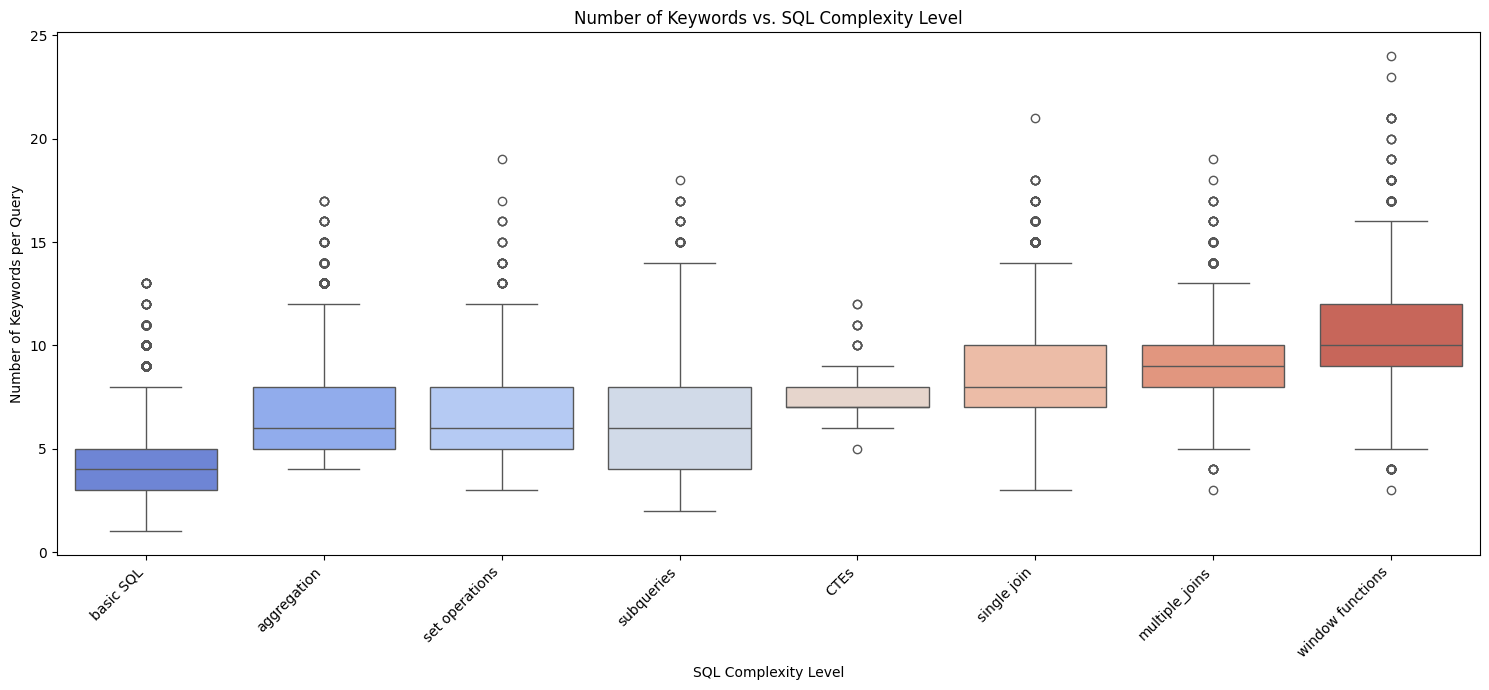

2025-04-21 17:54:40,585 - __main__ - INFO - Saved complexity vs. keyword count boxplot to './visualizations/complexity_boxplot.png'

--- SQL Complexity vs. Keyword Count Stats ---
                       mean  median  min  max       std  count
sql_complexity                                                
basic SQL          3.957207     4.0    1   13  1.444965  48466
aggregation        6.659550     6.0    4   17  2.172193  22015
set operations     6.948571     6.0    3   19  2.292114   1050
subqueries         6.557226     6.0    2   18  2.643099   6719
CTEs               7.597070     7.0    5   12  1.063564    273
single join        8.656376     8.0    3   21  2.127663  14932
multiple_joins     9.159715     9.0    3   19  2.227387   2949
window functions  10.293938    10.0    3   24  2.557397   3596


In [13]:
logger.info("\nAnalyzing relationship between SQL complexity level and keyword count...")
try:
    # Calculate the number of keywords per query (ensure 'sql_keywords' column exists)
    if 'sql_keywords' not in df_train.columns:
        raise KeyError("'sql_keywords' column not found. Ensure keyword analysis ran successfully.")
    df_train['keyword_count'] = df_train['sql_keywords'].apply(len)

    # Determine order for plotting based on median keyword count per complexity level
    complexity_order = df_train.groupby('sql_complexity')['keyword_count'].median().sort_values().index

    # Create boxplot
    plt.figure(figsize=(15, 7))
    sns.boxplot(x='sql_complexity', y='keyword_count', data=df_train, order=complexity_order, palette='coolwarm')
    plt.title('Number of Keywords vs. SQL Complexity Level')
    plt.xlabel('SQL Complexity Level')
    plt.ylabel('Number of Keywords per Query')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(os.path.join(viz_dir, 'complexity_boxplot.png'))
    plt.show() # Show the plot
    plt.close() # Close plot object
    logger.info(f"Saved complexity vs. keyword count boxplot to '{os.path.join(viz_dir, 'complexity_boxplot.png')}'")

    # Calculate and print summary statistics
    complexity_stats = df_train.groupby('sql_complexity')['keyword_count'].agg(['mean', 'median', 'min', 'max', 'std', 'count']).sort_values('median')
    print("\n--- SQL Complexity vs. Keyword Count Stats ---")
    print(complexity_stats)
except KeyError as e:
    logger.error(f"Missing column needed for complexity vs keyword analysis: {e}")
except Exception as e:
    logger.error(f"Error during complexity vs. keyword count analysis: {e}")



2025-04-21 17:54:40,604 - __main__ - INFO - 
Analyzing SQL context (CREATE TABLE statements)...
2025-04-21 17:54:40,605 - __main__ - INFO - Extracting table names and column counts from context...
2025-04-21 17:54:41,438 - __main__ - INFO - Context analysis complete.
2025-04-21 17:54:41,474 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-21 17:54:41,499 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


/var/folders/zw/rm73pxq9065980p1jg6sh01r0000gn/T/ipykernel_30820/1006649991.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=table_counts_to_plot, palette='pastel')


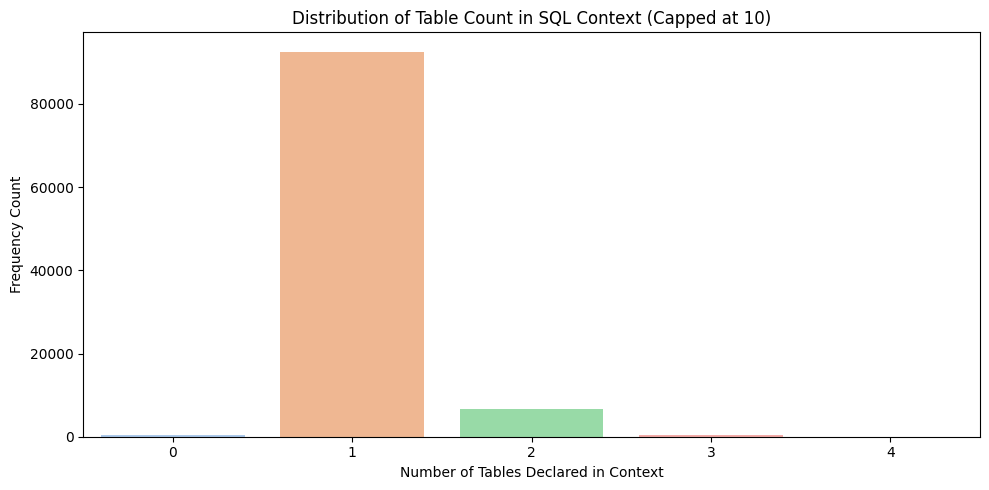

2025-04-21 17:54:41,616 - __main__ - INFO - Saved table count plot to './visualizations/table_count_distribution.png'


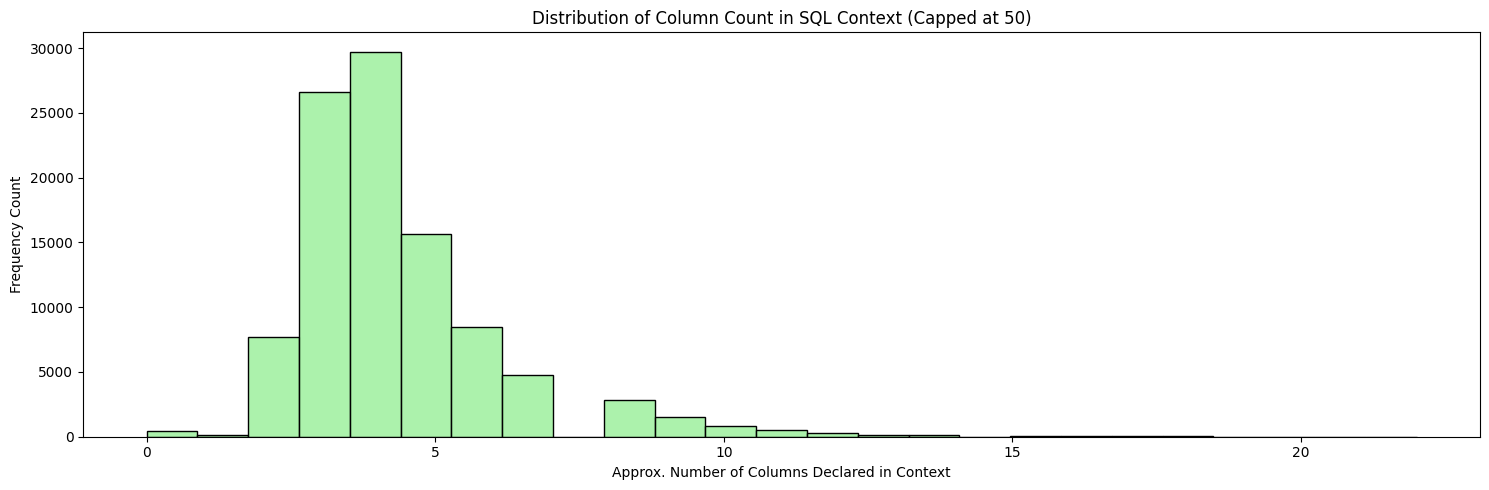

2025-04-21 17:54:41,840 - __main__ - INFO - Saved column count plot to './visualizations/column_count_distribution.png'

--- Table Count (Context) Stats ---
count    100000.000000
mean          1.069650
std           0.283795
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           4.000000
Name: table_count_in_context, dtype: float64

--- Column Count (Context) Stats ---
count    100000.000000
mean          4.376050
std           1.890104
min           0.000000
25%           3.000000
50%           4.000000
75%           5.000000
max          22.000000
Name: column_count_in_context, dtype: float64


In [14]:
logger.info("\nAnalyzing SQL context (CREATE TABLE statements)...")
try:
    def extract_table_names_from_context(sql_context):
        """Extract table names from CREATE TABLE statements using regex."""
        try:
            # Regex to find 'CREATE TABLE' followed by optional schema and table name (handling backticks)
            matches = re.findall(r'CREATE\s+TABLE\s+(?:IF\s+NOT\s+EXISTS\s+)?(?:`?(\w+)`?\.?)?`?(\w+)`?', str(sql_context), re.IGNORECASE)
            # Extract the table name, preferring the second capture group if schema is present
            tables = [m[1] if m[1] else m[0] for m in matches]
            return list(set(tables)) # Return unique table names
        except Exception as e:
            # logger.debug(f"Could not extract table names from context: {str(sql_context)[:100]}... Error: {e}")
            return []

    def count_columns_from_context(sql_context):
        """Approximate column count from CREATE TABLE statements using regex."""
        total_columns = 0
        try:
            # Find content within the main parentheses of CREATE TABLE statements
            # Using re.VERBOSE and triple quotes for robust multi-line regex
            create_statements_content = re.findall(
                r"""CREATE\s+TABLE.*? # Match CREATE TABLE and anything until parentheses
                    \(                 # Match the opening parenthesis
                    (.*?)              # Capture the content inside (non-greedy)
                    \)                 # Match the closing parenthesis
                    [^)]*?;            # Match until the statement semicolon, avoiding extra closing parens
                """,
                str(sql_context),
                re.IGNORECASE | re.DOTALL | re.VERBOSE
            )
            for content in create_statements_content:
                # Remove comments that might contain commas
                content_no_comments = re.sub(r'--.*?\n', '', content)
                content_no_comments = re.sub(r'/\*.*?\*/', '', content_no_comments, flags=re.DOTALL)
                # Remove nested parentheses content (e.g., CHECK constraints, type parameters)
                content_no_nested = re.sub(r'\([^)]*\)', '', content_no_comments)
                # Split by comma, considering potential trailing comma
                potential_col_defs = [line.strip() for line in content_no_nested.split(',') if line.strip()]
                # Count lines that likely start with a column name (simplistic check: starts with word char, possibly quoted)
                # This avoids counting CONSTRAINT definitions etc. as columns reliably
                col_count = sum(1 for line in potential_col_defs if re.match(r'^\s*[`"]?\w+[`"]?', line))
                total_columns += col_count
            return total_columns
        except Exception as e:
            # logger.debug(f"Could not count columns from context: {str(sql_context)[:100]}... Error: {e}")
            return 0

    # Apply the functions to the DataFrame
    logger.info("Extracting table names and column counts from context...")
    df_train['tables_in_context'] = df_train['sql_context'].apply(extract_table_names_from_context)
    df_train['table_count_in_context'] = df_train['tables_in_context'].apply(len)
    df_train['column_count_in_context'] = df_train['sql_context'].apply(count_columns_from_context)
    logger.info("Context analysis complete.")

    # Plot table count distribution
    plt.figure(figsize=(10, 5))
    # Clip counts for better visualization if the range is very wide
    table_counts_to_plot = df_train['table_count_in_context'].clip(upper=10)
    sns.countplot(x=table_counts_to_plot, palette='pastel')
    plt.title('Distribution of Table Count in SQL Context (Capped at 10)')
    plt.xlabel('Number of Tables Declared in Context')
    plt.ylabel('Frequency Count')
    plt.tight_layout()
    plt.savefig(os.path.join(viz_dir, 'table_count_distribution.png'))
    plt.show() # Show the plot
    plt.close() # Close plot object
    logger.info(f"Saved table count plot to '{os.path.join(viz_dir, 'table_count_distribution.png')}'")

    # Plot column count distribution
    plt.figure(figsize=(15, 5))
    # Clip column counts for visualization
    column_counts_to_plot = df_train['column_count_in_context'].clip(upper=50)
    sns.histplot(column_counts_to_plot, bins=25, kde=False, color='lightgreen')
    plt.title('Distribution of Column Count in SQL Context (Capped at 50)')
    plt.xlabel('Approx. Number of Columns Declared in Context')
    plt.ylabel('Frequency Count')
    plt.tight_layout()
    plt.savefig(os.path.join(viz_dir, 'column_count_distribution.png'))
    plt.show() # Show the plot
    plt.close() # Close plot object
    logger.info(f"Saved column count plot to '{os.path.join(viz_dir, 'column_count_distribution.png')}'")

    # Print descriptive statistics for context analysis
    print("\n--- Table Count (Context) Stats ---")
    print(df_train['table_count_in_context'].describe())
    print("\n--- Column Count (Context) Stats ---")
    print(df_train['column_count_in_context'].describe())

except KeyError as e:
    logger.error(f"Missing 'sql_context' column needed for context analysis: {e}")
except Exception as e:
    logger.error(f"Error during SQL context analysis: {e}")



In [15]:
logger.info(f"\nChecking SQL validity using sqlglot (on a sample of {eda_sample_size})...")
try:
    def check_sql_validity(sql):
        """Check if SQL can be parsed by sqlglot."""
        try:
            sqlglot.parse_one(str(sql)) # Ensure input is string
            return True
        except Exception:
            # Parsing failed
            return False

    # Take a random sample for this potentially slower check
    sample_indices = np.random.choice(df_train.index, size=min(eda_sample_size, len(df_train)), replace=False)
    df_sample = df_train.loc[sample_indices].copy() # Use .copy()

    # Apply validity check on the sample
    df_sample['is_valid_sql'] = df_sample['sql'].apply(check_sql_validity)
    valid_percentage = df_sample['is_valid_sql'].mean() * 100
    logger.info(f"Percentage of valid SQL queries in sample (n={len(df_sample)}): {valid_percentage:.2f}%")

    # Identify and display some invalid examples from the sample
    invalid_sql_examples = df_sample[~df_sample['is_valid_sql']]
    logger.info(f"Number of invalid SQL examples found in sample: {len(invalid_sql_examples)}")

    if not invalid_sql_examples.empty:
        logger.warning("\nSample invalid SQL examples (from sample set):")
        for i in range(min(3, len(invalid_sql_examples))):
            example = invalid_sql_examples.iloc[i]
            print(f"\n--- Invalid SQL Sample {i+1} ---")
            print(f"ID: {example.get('id', 'N/A')}") # Use .get for safety
            print(f"SQL: {example['sql']}")
            print("-" * 80)
    # Clean up sample DataFrame
    del df_sample
    # Attempt to collect garbage
    import gc
    gc.collect()

except KeyError as e:
    logger.error(f"Missing 'sql' column needed for validity check: {e}")
except Exception as e:
    logger.error(f"Error during SQL validity check: {e}")



2025-04-21 17:54:41,850 - __main__ - INFO - 
Checking SQL validity using sqlglot (on a sample of 1000)...
2025-04-21 17:54:42,100 - __main__ - INFO - Percentage of valid SQL queries in sample (n=1000): 99.90%
2025-04-21 17:54:42,101 - __main__ - INFO - Number of invalid SQL examples found in sample: 1
2025-04-21 17:54:42,101 - __main__ - WARNING - 
Sample invalid SQL examples (from sample set):

--- Invalid SQL Sample 1 ---
ID: 47314
SQL: SELECT gender, researcher, COUNT(DISTINCT id) as num_grants FROM grant WHERE division = 'Business' GROUP BY gender, researcher ORDER BY num_grants DESC;
--------------------------------------------------------------------------------


2025-04-21 17:54:42,212 - __main__ - INFO - 
Analyzing token counts using 'google/gemma-3-1b-it' tokenizer (on a sample of 1000)...
2025-04-21 17:54:42,213 - __main__ - INFO - Loading tokenizer: google/gemma-3-1b-it
2025-04-21 17:54:43,104 - __main__ - INFO - Tokenizer loaded successfully.
2025-04-21 17:54:43,107 - __main__ - INFO - Calculating token counts for sample size: 1000


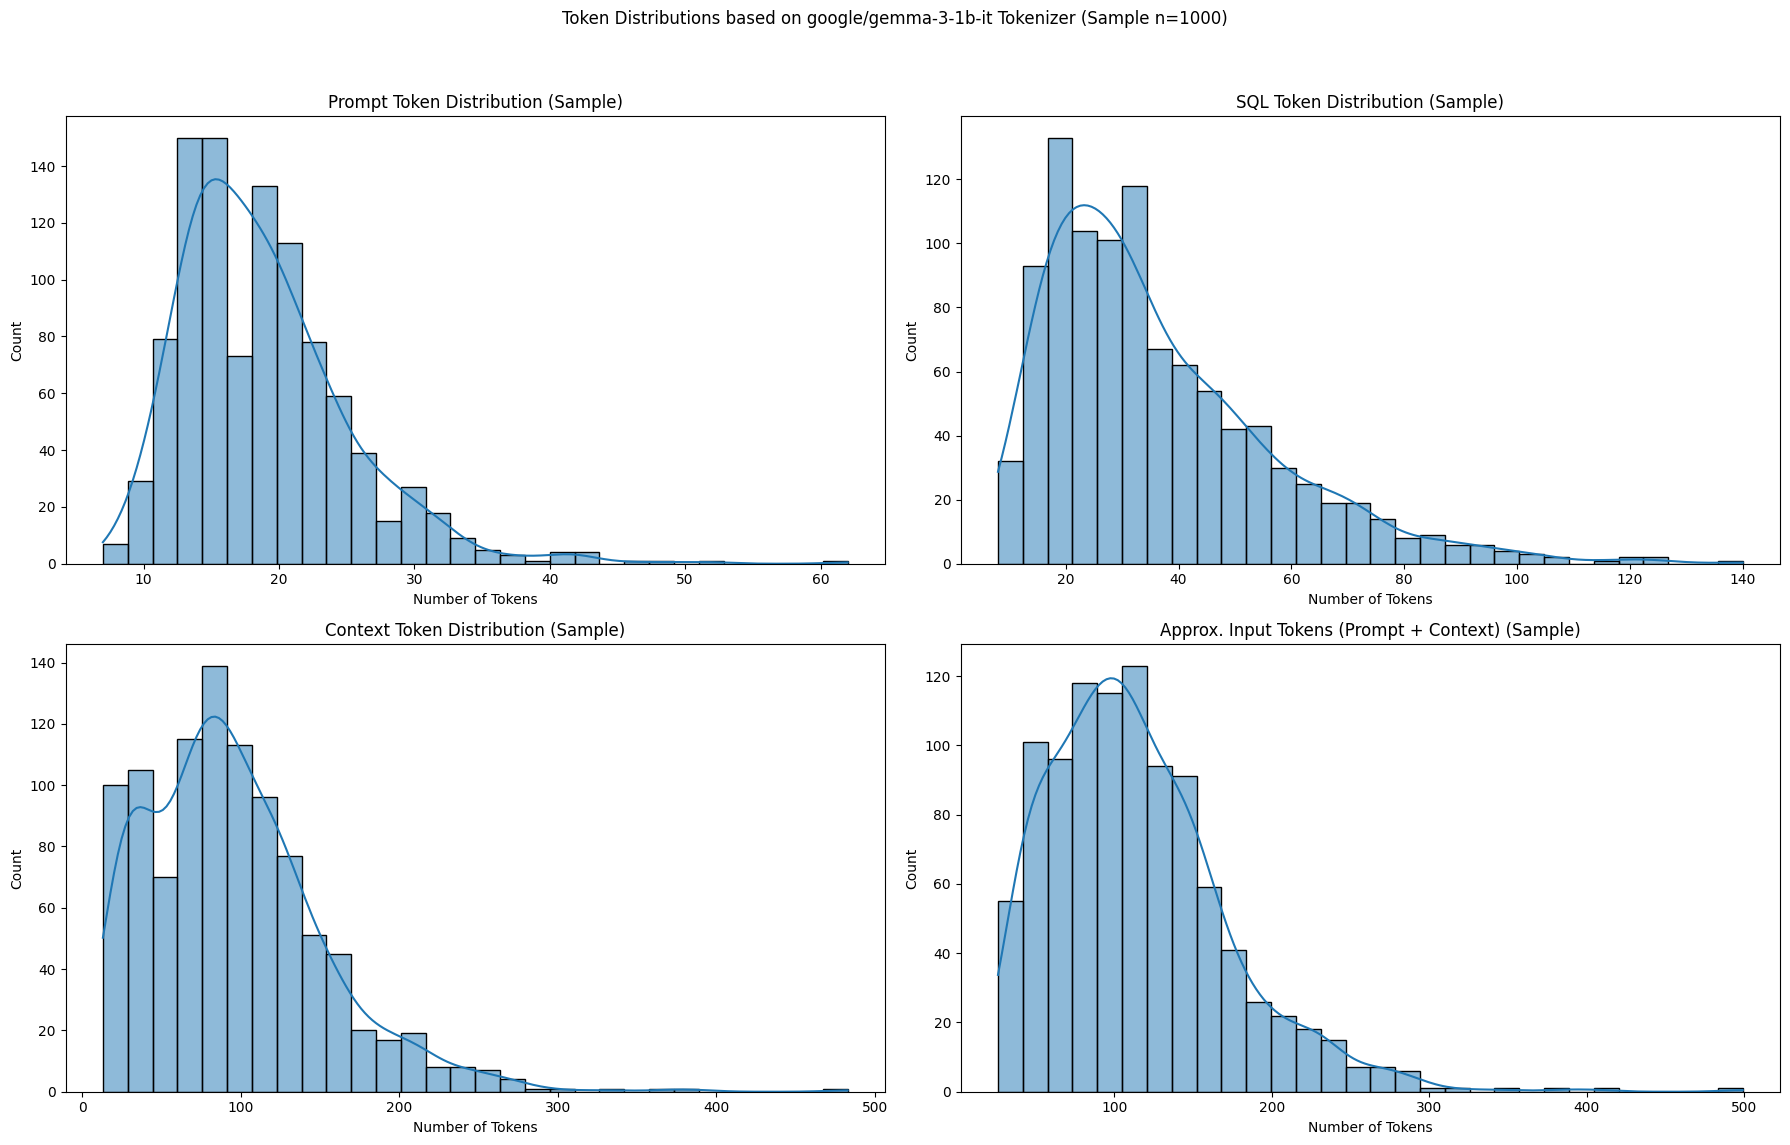

2025-04-21 17:54:43,625 - __main__ - INFO - Saved token distribution plots to './visualizations/token_distributions.png'

--- Token Stats (Sample) ---
Prompt tokens:
count    1000.0000
mean       18.8180
std         6.3368
min         7.0000
25%        14.0000
50%        18.0000
75%        22.0000
max        62.0000
Name: prompt_tokens, dtype: float64

SQL tokens:
count    1000.000000
mean       36.259000
std        20.374765
min         8.000000
25%        21.000000
50%        31.000000
75%        46.000000
max       140.000000
Name: sql_tokens, dtype: float64

Context tokens:
count    1000.000000
mean       95.336000
std        56.664362
min        13.000000
25%        55.000000
50%        88.000000
75%       125.000000
max       483.000000
Name: context_tokens, dtype: float64

Approx Input tokens (Prompt + Context):
count    1000.000000
mean      114.154000
std        57.068267
min        26.000000
25%        73.000000
50%       106.000000
75%       145.000000
max       499.000000
N

In [16]:
# This section depends on the transformers library and access to the specified model's tokenizer
logger.info(f"\nAnalyzing token counts using '{model_name}' tokenizer (on a sample of {eda_sample_size})...")
tokenizer = None # Initialize tokenizer variable
try:
    logger.info(f"Loading tokenizer: {model_name}")
    tokenizer_params = {}
    if hf_token:
        tokenizer_params['token'] = hf_token # Use token if available
    # Load the tokenizer associated with the model chosen for fine-tuning
    tokenizer = AutoTokenizer.from_pretrained(model_name, **tokenizer_params)
    logger.info("Tokenizer loaded successfully.")

    # Calculate token counts on a sample for efficiency
    sample_indices = np.random.choice(df_train.index, size=min(eda_sample_size, len(df_train)), replace=False)
    df_token_sample = df_train.loc[sample_indices].copy() # Use .copy()
    logger.info(f"Calculating token counts for sample size: {len(df_token_sample)}")

    def count_tokens(text):
        """Safely count tokens using the loaded tokenizer."""
        # Handle potential NaN or None values
        if pd.isna(text):
            return 0
        try:
            # Ensure text is string and encode
            return len(tokenizer.encode(str(text)))
        except Exception as e:
            # Log encoding errors for specific text snippets if needed for debugging
            # logger.debug(f"Could not tokenize text: {str(text)[:50]}... Error: {e}")
            return 0 # Return 0 if tokenization fails

    # Apply token counting to relevant columns
    df_token_sample['prompt_tokens'] = df_token_sample['sql_prompt'].apply(count_tokens)
    df_token_sample['sql_tokens'] = df_token_sample['sql'].apply(count_tokens)
    df_token_sample['context_tokens'] = df_token_sample['sql_context'].apply(count_tokens)
    # Estimate total input tokens assuming a simple concatenation format (Prompt + Context)
    df_token_sample['approx_input_tokens'] = df_token_sample['prompt_tokens'] + df_token_sample['context_tokens']

    # Plot token distributions
    plt.figure(figsize=(18, 12))

    plt.subplot(2, 2, 1)
    sns.histplot(df_token_sample['prompt_tokens'], bins=30, kde=True)
    plt.title('Prompt Token Distribution (Sample)')
    plt.xlabel('Number of Tokens')

    plt.subplot(2, 2, 2)
    sns.histplot(df_token_sample['sql_tokens'], bins=30, kde=True)
    plt.title('SQL Token Distribution (Sample)')
    plt.xlabel('Number of Tokens')

    plt.subplot(2, 2, 3)
    sns.histplot(df_token_sample['context_tokens'], bins=30, kde=True)
    plt.title('Context Token Distribution (Sample)')
    plt.xlabel('Number of Tokens')

    plt.subplot(2, 2, 4)
    sns.histplot(df_token_sample['approx_input_tokens'], bins=30, kde=True)
    plt.title('Approx. Input Tokens (Prompt + Context) (Sample)')
    plt.xlabel('Number of Tokens')

    plt.suptitle(f'Token Distributions based on {model_name} Tokenizer (Sample n={len(df_token_sample)})')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout
    plt.savefig(os.path.join(viz_dir, 'token_distributions.png'))
    plt.show() # Show the plot
    plt.close() # Close plot object
    logger.info(f"Saved token distribution plots to '{os.path.join(viz_dir, 'token_distributions.png')}'")

    # Print descriptive statistics for token counts
    print("\n--- Token Stats (Sample) ---")
    print(f"Prompt tokens:\n{df_token_sample['prompt_tokens'].describe()}")
    print(f"\nSQL tokens:\n{df_token_sample['sql_tokens'].describe()}")
    print(f"\nContext tokens:\n{df_token_sample['context_tokens'].describe()}")
    print(f"\nApprox Input tokens (Prompt + Context):\n{df_token_sample['approx_input_tokens'].describe()}")

    # Clean up sample DataFrame
    del df_token_sample
    # Attempt garbage collection
    import gc
    gc.collect()

except ImportError:
     logger.error("Fatal: `transformers` library not found. Cannot perform token analysis.")
     logger.error("Please install it: pip install transformers")
except KeyError as e:
    logger.error(f"Missing column needed for token analysis: {e}")
except Exception as e:
    logger.error(f"Error during token analysis: {e}")
    if "requires you to be logged in" in str(e).lower():
         logger.error("Try logging in via `huggingface-cli login` or setting HF_TOKEN environment variable.")
    elif "not found" in str(e).lower() or "doesn't exist" in str(e).lower():
         logger.error(f"Model name '{model_name}' might be incorrect, private, or require specific access.")
finally:
    # Ensure tokenizer is deleted even if errors occurred during analysis
    if 'tokenizer' in locals() and tokenizer is not None:
        del tokenizer
        logger.info("Tokenizer unloaded.")



2025-04-21 17:54:43,793 - __main__ - INFO - 
Analyzing correlation between prompt length and SQL complexity (sample)...


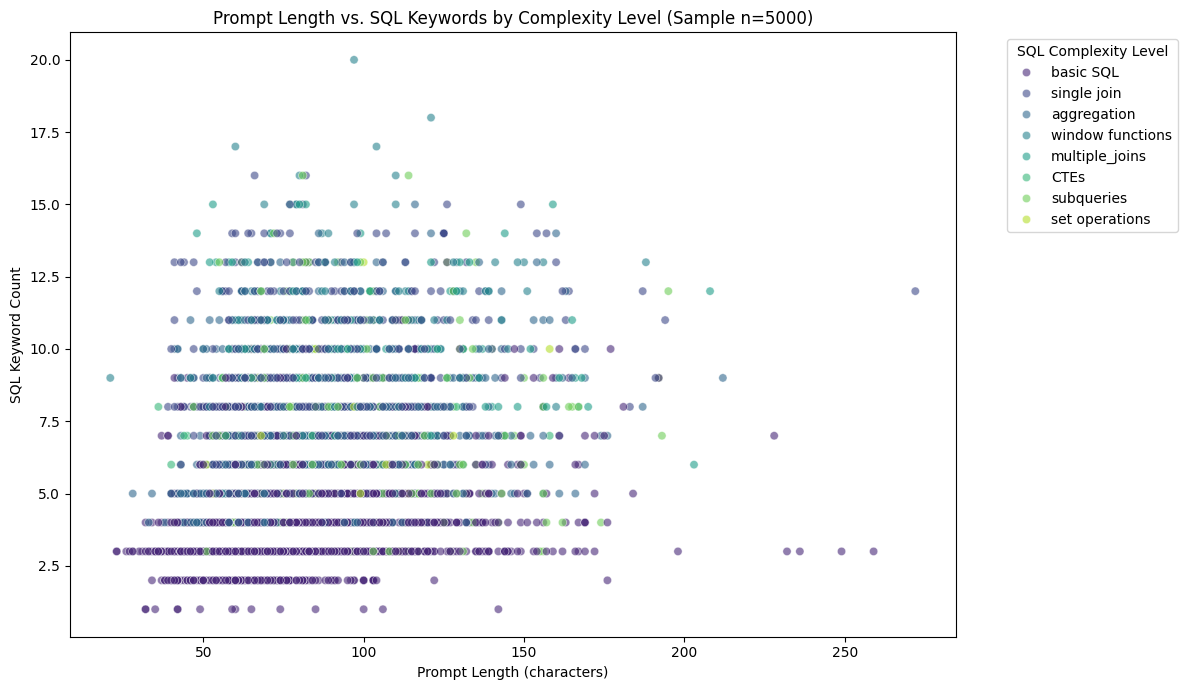

2025-04-21 17:54:44,026 - __main__ - INFO - Saved complexity correlation plot to './visualizations/prompt_sql_complexity_correlation.png'


In [17]:
logger.info("\nAnalyzing correlation between prompt length and SQL complexity (sample)...")
try:
    # Check required columns exist before sampling
    required_cols = ['prompt_length', 'keyword_count', 'sql_complexity']
    if not all(col in df_train.columns for col in required_cols):
        missing_cols = [col for col in required_cols if col not in df_train.columns]
        raise KeyError(f"Missing required columns for correlation analysis: {missing_cols}")

    # Use a larger sample for correlation visualization if available, capped for performance
    corr_sample_size = min(5000, len(df_train))
    df_corr_sample = df_train.sample(n=corr_sample_size, random_state=42)

    plt.figure(figsize=(12, 7))
    sns.scatterplot(
        x='prompt_length',
        y='keyword_count',
        hue='sql_complexity',
        data=df_corr_sample,
        alpha=0.6, # Use transparency to see overlapping points
        palette='viridis'
    )
    plt.title(f'Prompt Length vs. SQL Keywords by Complexity Level (Sample n={corr_sample_size})')
    plt.xlabel('Prompt Length (characters)')
    plt.ylabel('SQL Keyword Count')
    plt.legend(title='SQL Complexity Level', bbox_to_anchor=(1.05, 1), loc='upper left') # Place legend outside plot
    plt.tight_layout()
    plt.savefig(os.path.join(viz_dir, 'prompt_sql_complexity_correlation.png'))
    plt.show() # Show the plot
    plt.close() # Close plot object
    logger.info(f"Saved complexity correlation plot to '{os.path.join(viz_dir, 'prompt_sql_complexity_correlation.png')}'")

    # Clean up sample DataFrame
    del df_corr_sample
    # Attempt garbage collection
    import gc
    gc.collect()

except KeyError as e:
    logger.error(f"Skipping correlation analysis: {e}")
except Exception as e:
    logger.error(f"Failed to plot complexity correlation: {e}")



In [18]:
logger.info("\nEDA script finished.")
logger.info(f"Visualizations saved in: {viz_dir}")
logger.info("Review plots and printed statistics.")

2025-04-21 17:54:44,137 - __main__ - INFO - 
EDA script finished.
2025-04-21 17:54:44,138 - __main__ - INFO - Visualizations saved in: ./visualizations
2025-04-21 17:54:44,138 - __main__ - INFO - Review plots and printed statistics.
